# I will try to use custom loss,multi-sample droput,initial weight, exploding gradient, adamw,early stopping stratified K-fold, oof, etc

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ptfrrulabel-s2-bin/__results__.html
/kaggle/input/ptfrrulabel-s2-bin/x_train.npy
/kaggle/input/ptfrrulabel-s2-bin/__notebook__.ipynb
/kaggle/input/ptfrrulabel-s2-bin/custom.css
/kaggle/input/ptfrrulabel-s2-bin/y_train_lb_1024.npy
/kaggle/input/ptfrrulabel-s2-bin/__output__.json
/kaggle/input/s1-finaleseries/__results__.html
/kaggle/input/s1-finaleseries/__notebook__.ipynb
/kaggle/input/s1-finaleseries/s1_en.h5
/kaggle/input/s1-finaleseries/custom.css
/kaggle/input/s1-finaleseries/s1_en.csv
/kaggle/input/s1-finaleseries/__output__.json
/kaggle/input/s1-finaleseries/__results___files/__results___25_1.png
/kaggle/input/s1-finaleseries/__results___files/__results___26_1.png
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classifica

# HEADER IMPORTS

In [2]:
!pip install iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
!pip install transformers
import transformers
from transformers import TFAutoModel, AutoTokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
!pip install gin-config==0.1.1

     |████████████████████████████████| 40 kB 1.7 MB/s 
  Created wheel for gin-config: filename=gin_config-0.1.1-py3-none-any.whl size=38329 sha256=bb4c4ac8743252d841efbca35590a68d8ab90d24162804612e19ec18d666188b
  Stored in directory: /root/.cache/pip/wheels/26/b3/1b/b745a6f67881260cf669db1d4fc55d0c961e1e0d6317fdf606
Successfully built gin-config


In [5]:
from keras import backend as K
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tensorflow.keras import layers as L
import keras
from keras.utils import to_categorical
import gc

Using TensorFlow backend.


In [6]:
def scheduler(epoch):
    if epoch <=1:
        return 0.000007
    else:
        return 0.000007 /(epoch * 0.75)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [7]:
x_train = np.load('/kaggle/input/ptfrrulabel-bin/x_train.npy')
x_valid = np.load('/kaggle/input/validtestlb/x_valid.npy')
x_test = np.load('/kaggle/input/validtestlb/x_test.npy')

y_valid = np.load('/kaggle/input/validtestlb/y_valid_lb_1024.npy')
y_train = np.load('/kaggle/input/ptfrrulabel-bin/y_train_lb_1024.npy')
import sklearn
x_train, y_train = sklearn.utils.shuffle(x_train, y_train)





In [8]:
MAX_LEN = 256  #Reduced for quicker execution
LR = 0.000007
BATCH_SIZE = 16 # per TPU core
TOTAL_STEPS_STAGE1 = len(x_train)//(16*8)
VALIDATE_EVERY_STAGE1 = 100
TOTAL_STEPS_STAGE2 = 200
VALIDATE_EVERY_STAGE2 = 100
label_bins = 1024

PRETRAINED_MODEL = 'jplu/tf-xlm-roberta-large'
D = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'

import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import transformers
from transformers import TFAutoModel, AutoTokenizer
import logging
# no extensive logging 
logging.getLogger().setLevel(logging.NOTSET)

AUTO = tf.data.experimental.AUTOTUNE

2.2.0


In [9]:
def connect_to_TPU():
    """Detect hardware, return appropriate distribution strategy"""
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

    return tpu, strategy, global_batch_size


tpu, strategy, global_batch_size = connect_to_TPU()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [10]:
def create_dist_dataset(X, y=None, training=False):
    dataset = tf.data.Dataset.from_tensor_slices(X)

    ### Add y if present ###
    if y is not None:
        dataset_y = tf.data.Dataset.from_tensor_slices(y)
        dataset = tf.data.Dataset.zip((dataset, dataset_y))
        
#     ### Repeat if training ###
#     if training:
#         dataset = dataset.shuffle(len(X)).repeat()

    dataset = dataset.batch(global_batch_size).prefetch(AUTO)

    ### make it distributed  ###
    dist_dataset = strategy.experimental_distribute_dataset(dataset)

    return dist_dataset
    
    
train_dist_dataset = create_dist_dataset(x_train, y_train, True)
val_dist_dataset   = create_dist_dataset(x_valid)
test_dist_dataset  = create_dist_dataset(x_test)

In [11]:
%%time

def create_model_and_optimizer():
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(PRETRAINED_MODEL)                
        model = build_model(transformer_layer)
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR, epsilon=1e-06)
    return model, optimizer


def build_model(transformer):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out1 = tf.keras.layers.Dense(10240, activation='relu', kernel_initializer=tf.initializers.he_normal())(cls_token)
    out2 = tf.keras.layers.Dropout(0.35)(out1)
    out3 = tf.keras.layers.Dense(5120, activation='relu', kernel_initializer=tf.initializers.he_normal())(out2)
    FC = tf.keras.layers.Dense(label_bins, activation='sigmoid')
    fcdropouts = []
    for i in range(5):
        x = tf.keras.layers.Dropout(0.5)(out3)
        x = FC(x)
        fcdropouts.append(x)
        
    out = tf.keras.layers.Average()(fcdropouts)

    model = Model(inputs=[input_word_ids], outputs=[out])
#     model.compile(optimizer=Adam(0.000007), loss ='binary_crossentropy',metrics=[precision_m, f1_m, recall_m])
    
    return model

model, optimizer = create_model_and_optimizer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 256, 1024),  559890432   input_word_ids[0][0]             
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 1024)]       0           tf_roberta_model[0][0]           
__________________________________________________________________________________________________
dense (Dense)                   (None, 10240)        10496000    tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

In [12]:
model.load_weights('/kaggle/input/s1-finaleseries/s1_en.h5')

In [13]:
def metric_tf(y_true, y_pred):
    recall = 0
    precision = 0
    f1=0
#     if (K.int_shape(y_pred))[1]== label_bins and (K.int_shape(y_true))[1]== label_bins:
    y_true = K.cast(K.greater_equal(K.cast(K.mean(y_true,1),'float32'), K.constant(0.5)),'int32')
    y_pred = K.cast(K.greater_equal(K.cast(K.mean(y_pred,1),'float32'), K.constant(0.5)),'int32')
    true_positives = K.cast(K.sum(y_true * y_pred),'float32')
    possible_positives = K.cast(K.sum(y_true),'float32')
    predicted_positives = K.cast(K.sum(y_pred),'float32')
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    f1=2*((precision*recall)/(precision+recall+K.epsilon()))
    return recall, precision, f1

In [14]:
def metric(y_true, y_pred):
    recall = 0
    precision = 0
    f1=0
    y_true = (np.sum(y_true,axis=1)/label_bins)        
    y_true[y_true >= .5] = 1
    y_true[y_true < .5] = 0
    y_pred = (np.sum(y_pred,axis=1)/label_bins)    
    y_pred[y_pred >= .5] = 1
    y_pred[y_pred < .5] = 0
    true_positives = int(np.sum(y_true * y_pred))
    possible_positives = int(np.sum(y_true))
    predicted_positives = int(np.sum(y_pred))
    recall = true_positives / (possible_positives + 1e-07)
    precision = true_positives / (predicted_positives + 1e-07)
    f1=2*((precision*recall)/(precision+recall+1e-07))
    return recall, precision, f1

In [15]:
def metrics_tef(labels, predictions):
    recall,precision,f1=metric_tf(labels, predictions)
    return recall,precision,f1

In [16]:
def define_losses_and_metrics():
    with strategy.scope():
        recall,precision,f1=0,0,0
        loss_object = tf.keras.losses.BinaryCrossentropy(
            reduction=tf.keras.losses.Reduction.NONE, from_logits=False)
        def compute_loss(labels, predictions):
            per_example_loss = loss_object(labels, predictions)
            loss = tf.nn.compute_average_loss(
                per_example_loss, global_batch_size = global_batch_size)
            return loss
        def metrics_tef(labels, predictions):
            recall,precision,f1=metric_tf(labels, predictions)
        train_accuracy_metric = tf.keras.metrics.AUC(name='training_AUC')
        
    return compute_loss, train_accuracy_metric, recall,precision,f1

In [17]:
def train(train_dist_dataset, val_dist_dataset=None, y_val=None,
          total_steps=5000, validate_every=500):
    best_weights, history = None, []
    step = 0
    total_loss = 0.0
    total_recall = 0.0
    total_precision = 0.0
    total_f1 = 0.0
    ### Training lopp ###
    for tensor in train_dist_dataset:
#         total_loss=total_loss+distributed_train_step(tensor)
        loss, recall,precision,f1 = distributed_train_step(tensor)
        total_loss=loss+total_loss
        total_recall=recall+total_recall
        total_precision=precision+total_precision
        total_f1=f1+total_f1
        
        step+=1

        
        if (step % validate_every == 0):
                ### Print train metrics ###  
                
            train_loss = total_loss / step
            train_recall = total_recall / step
            train_precision = total_precision / step
            train_f1 = total_f1 / step    
            train_metric = train_accuracy_metric.result().numpy()

#             print(recall.eval(session=tf.compat.v1.Session()))
            print("Step %d, train AUC: %.5f" % (step, train_metric))
            print("Step %d, train_loss: %.5f" % (step, train_loss))
            print("Step %d, train_recall: %.5f" % (step, train_recall))
            print("Step %d, total_precision: %.5f" % (step, train_precision))
            print("Step %d, total_f1: %.5f" % (step, train_f1))
#             pre=tf.keras.backend.eval(loss)
#             print(pre)
            ### Test loop with exact AUC ###
    #         del y_pred_train
            if val_dist_dataset:
                y_pred_val = predict(val_dist_dataset)
                recall_v,precision_v,f1_v=metric(y_valid,y_pred_val)
                x=(np.sum(y_valid, axis = 1)/label_bins).astype('int32')
                x[x >= .5 ] = 1
                x[x < .5 ] = 0
                val_metric = roc_auc_score(x, (np.sum(y_pred_val, axis = 1)/label_bins))
                print("     validation AUC: %.5f" %  val_metric)
                print("     validation precision: %.5f" %  precision_v)
                print("     validation recall: %.5f" %  recall_v)        
                print("     validation f1: %.5f" %  f1_v)
                
#                 # save weights if it is the best yet
#                 history.append(val_metric)
#                 if history[-1] == max(history):
#                     best_weights = model.get_weights()
                    
                    
    #             del y_pred_val
            ### Reset (train) metrics ###
            train_accuracy_metric.reset_states()
            
        if step  == total_steps:
            break
#     model.set_weights(best_weights)


@tf.function
def distributed_train_step(data):
    per_replica_losses, p_recall,p_precision,p_f1 = strategy.run(train_step, args=(data,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None), strategy.reduce(tf.distribute.ReduceOp.MEAN, p_recall,
                         axis=None),strategy.reduce(tf.distribute.ReduceOp.MEAN, p_precision,
                         axis=None),strategy.reduce(tf.distribute.ReduceOp.MEAN, p_f1,
                         axis=None)

def train_step(inputs):
    features, labels = inputs

    with tf.GradientTape() as tape:
        predictions = model(features, training=True)
        loss = compute_loss(labels, predictions)
        recall,precision,f1=metrics_tef(labels, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_accuracy_metric.update_state(labels, predictions)
    return loss, recall,precision,f1
#     tf.print(precision)
#     print("      recall: %.5f" %  recall.numpy())
#     print("      f1: %.5f" %  f1.numpy())
#     train_accuracy_metric.update_state(labels, predictions)

In [18]:
def predict(dataset):  
    predictions = []
    for tensor in dataset:
        predictions.append(distributed_prediction_step(tensor))
    ### stack replicas and batches
    predictions = np.vstack(list(map(np.vstack,predictions)))
    return predictions

@tf.function
def distributed_prediction_step(data):
    predictions = strategy.experimental_run_v2(prediction_step, args=(data,))
    return strategy.experimental_local_results(predictions)

def prediction_step(inputs):
    features = inputs  # note datasets used in prediction do not have labels
    predictions = model(features, training=False)
    return predictions

compute_loss, train_accuracy_metric, recall, precision, f1 = define_losses_and_metrics()

In [19]:
%%time
train(train_dist_dataset, val_dist_dataset, y_valid,
      TOTAL_STEPS_STAGE1, VALIDATE_EVERY_STAGE1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


Step 100, train AUC: 0.94913
Step 100, train_loss: 0.28533
Step 100, train_recall: 0.60871
Step 100, total_precision: 0.14800
Step 100, total_f1: 0.22842
     validation AUC: 0.93122
     validation precision: 0.53536
     validation recall: 0.80000
     validation f1: 0.64146
Step 200, train AUC: 0.95236
Step 200, train_loss: 0.28078
Step 200, train_recall: 0.61429
Step 200, total_precision: 0.15062
Step 200, total_f1: 0.23200
     validation AUC: 0.93505
     validation precision: 0.54247
     validation recall: 0.82033
     validation f1: 0.65307
Step 300, train AUC: 0.95508
Step 300, train_loss: 0.27654
Step 300, train_recall: 0.61723
Step 300, total_precision: 0.15029
Step 300, total_f1: 0.23180
     validation AUC: 0.93507
     validation precision: 0.54037
     validation recall: 0.83252
     validation f1: 0.65536
Step 400, train AUC: 0.95532
Step 400, train_loss: 0.27422
Step 400, train_recall: 0.61402
Step 400, total_precision: 0.15052
Step 400, total_f1: 0.23144
     validat

In [20]:
# %%time
# # make a new dataset for training with the validation data 
# # with targets, shuffling and repeating
# val_dist_dataset_4_training = create_dist_dataset(x_valid, y_valid, training=True)

# # train again
# train(val_dist_dataset_4_training,
#       total_steps = TOTAL_STEPS_STAGE2, 
#       validate_every = VALIDATE_EVERY_STAGE2)  # not validating but printing now

In [21]:
model.save_weights('s1_en_with_multi3l.h5')

In [22]:
x = predict(test_dist_dataset)

In [23]:
X=[]
for a in (x):
    X.append(float(sum(a)/len(a)))


In [24]:
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
test['toxic'] = np.array(X)
sub = test[['id', 'toxic']]
sub.to_csv('s1_en_multi3l.csv', index=False)

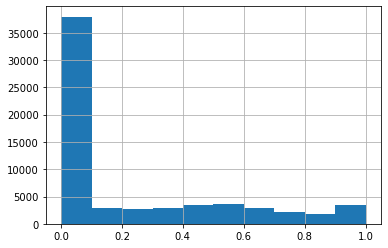

In [25]:
sub['toxic'].hist()

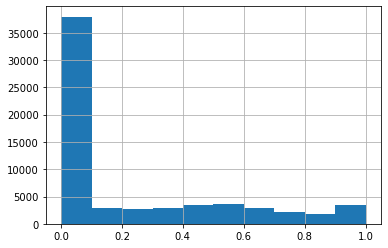

In [26]:
sub['toxic'].hist()